Choose input method:
1. Use predefined complex graph (50 nodes, 200 edges)
2. Enter custom graph parameters
Enter choice (1 or 2): 2
Enter the graph parameters:
Known chromatic number: 5
Number of vertices: 4
Number of edges: 5
Enter 5 edges (one per line, space-separated vertices):
0 1
0 2
0 3
1 3
2 3

Input Summary:
Known chromatic number: 5 (used only for reference)
Number of vertices: 4
Number of edges: 5

Adjacency List Representation:
Vertex 0: [1, 2, 3]
Vertex 1: [0, 3]
Vertex 2: [0, 3]
Vertex 3: [0, 1, 2]
Gen   1 | Conflicts:  1- 5 (avg   2.5) | Colors:  1.9

Best Solution Found:
Sequence: [1, 2, 2, 3]
Number of conflicts: 0
Number of colors used: 3
Known chromatic number (reference): 5
Note: Algorithm found the minimal coloring independently


<ipython-input-17-d85fe8ef9aa5>:210: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_colors))


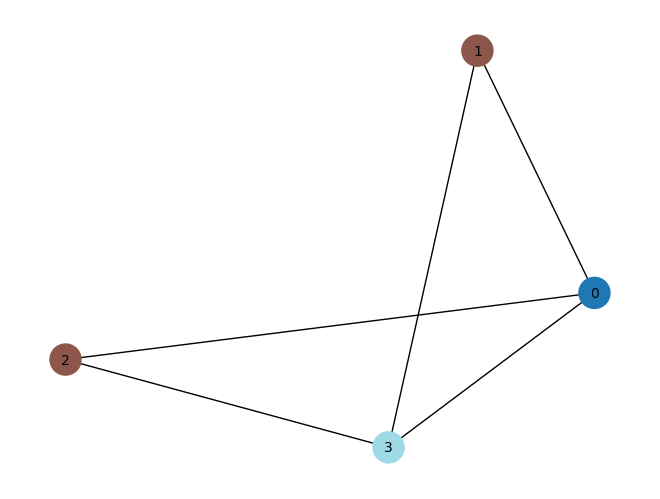

In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt

# Algorithm parameters - these are hyperparameters that control the genetic algorithm
NUM_CHROMOSOMES = 100  # Population size
CROSS_PROBABILITY = 0.85  # Probability of crossover occurring between two parents
MUTATE_PROBABILITY = 0.3  # Probability of mutation occurring in a chromosome
NUM_GENERATIONS = 1000  # Maximum number of generations to run
ELITISM_COUNT = 2  # Number of best chromosomes to carry over unchanged to next generation

class Chromosome:
    def __init__(self, num_vertices):
        # Initialize a chromosome with random colors (starting with minimal possible colors - 2)
        self.sequence = [random.randint(1, 2) for _ in range(num_vertices)]
        self.num_conflicts = 0  # Number of adjacent nodes with same color
        self.fitness = 0  # Fitness score (higher is better)
        self.update_colors_used()  # Calculate how many unique colors are being used

    def copy(self):
        # Create a deep copy of the chromosome
        new_chromosome = Chromosome(len(self.sequence))
        new_chromosome.sequence = self.sequence[:]  # Copy the color sequence
        new_chromosome.num_conflicts = self.num_conflicts
        new_chromosome.fitness = self.fitness
        new_chromosome.num_colors_used = self.num_colors_used
        return new_chromosome

    def update_colors_used(self):
        # Calculate how many unique colors are in the sequence
        self.num_colors_used = len(set(self.sequence))

def find_conflict(edges, colors):
    # Count how many edges have nodes with the same color (conflicts)
    return sum(1 for u, v in edges if colors[u] == colors[v])

def evaluate_population(edges, chromosomes):
    # Evaluate each chromosome in the population
    for chrom in chromosomes:
        chrom.num_conflicts = find_conflict(edges, chrom.sequence)
        chrom.update_colors_used()

        # Fitness function design:
        # Prioritize 1) Zero conflicts, 2) Fewer colors
        if chrom.num_conflicts == 0:
            # Maximum score for valid coloring, with bonus for fewer colors
            chrom.fitness = 10000 - chrom.num_colors_used
        else:
            # Penalize conflicts heavily
            chrom.fitness = -chrom.num_conflicts

def select_chromosomes(chromosomes):
    # Tournament selection with size 5
    selected = []
    # Select enough chromosomes to maintain population size (minus elites)
    for _ in range(len(chromosomes) - ELITISM_COUNT):
        # Randomly sample 5 chromosomes and pick the best one
        candidates = random.sample(chromosomes, 5)
        selected.append(max(candidates, key=lambda x: x.fitness).copy())
    return selected

def crossover(parent1, parent2):
    # Perform two-point crossover between two parents
    size = len(parent1.sequence)
    # Choose two random points and sort them
    pt1, pt2 = sorted(random.sample(range(size), 2))
    # Swap the segments between the two points
    parent1.sequence[pt1:pt2], parent2.sequence[pt1:pt2] = (
        parent2.sequence[pt1:pt2], parent1.sequence[pt1:pt2])

def mutate(chromosome):
    # Conflict-directed mutation - focuses on problematic nodes
    conflicting_nodes = []
    # Find all nodes involved in conflicts
    for u, v in edges:
        if chromosome.sequence[u] == chromosome.sequence[v]:
            conflicting_nodes.extend([u, v])

    # If no conflicts, mutate random nodes
    nodes_to_mutate = conflicting_nodes if conflicting_nodes else range(len(chromosome.sequence))

    # Mutate up to 5 nodes (or all if fewer than 5)
    for node in random.sample(nodes_to_mutate, min(5, len(nodes_to_mutate))):
        # Find colors of neighboring nodes
        neighbor_colors = set()
        for u, v in edges:
            if u == node:
                neighbor_colors.add(chromosome.sequence[v])
            elif v == node:
                neighbor_colors.add(chromosome.sequence[u])

        # Try to find a non-conflicting color
        current_color = chromosome.sequence[node]
        available_colors = [c for c in range(1, chromosome.num_colors_used + 2)
                          if c not in neighbor_colors]

        if available_colors:
            # Prefer smaller color numbers if available
            chromosome.sequence[node] = min(available_colors)
        else:
            # if no conflict-free color, assign smallest possible color
            chromosome.sequence[node] = min(set(range(1, chromosome.num_colors_used + 2)) - neighbor_colors,
                                          default=random.randint(1, chromosome.num_colors_used))

def genetic_algorithm(edges, num_vertices):
    # initialize population
    population = [Chromosome(num_vertices) for _ in range(NUM_CHROMOSOMES)]
    best_solution = None

    # main generational loop
    for generation in range(1, NUM_GENERATIONS + 1):
        evaluate_population(edges, population)

        # track best solution found so far
        current_best = max(population, key=lambda x: x.fitness)
        if best_solution is None or (current_best.fitness > best_solution.fitness):
            best_solution = current_best.copy()

        # early termination if perfect solution found
        if best_solution.num_conflicts == 0:
            # try to reduce colors further if possible
            if best_solution.num_colors_used > 2:
                best_solution = try_reduce_colors(best_solution, edges)
            break

        # print progress information
        min_conflict = min(chrom.num_conflicts for chrom in population)
        max_conflict = max(chrom.num_conflicts for chrom in population)
        avg_conflict = sum(chrom.num_conflicts for chrom in population) / NUM_CHROMOSOMES
        avg_colors = sum(chrom.num_colors_used for chrom in population) / NUM_CHROMOSOMES
        print(f"Gen {generation:3d} | Conflicts: {min_conflict:2d}-{max_conflict:2d} (avg {avg_conflict:5.1f}) | Colors: {avg_colors:4.1f}")

        # selection and reproduction
        elites = sorted(population, key=lambda x: -x.fitness)[:ELITISM_COUNT]
        mating_pool = select_chromosomes(population)

        # crossover
        for i in range(0, len(mating_pool) - 1, 2):
            if random.random() < CROSS_PROBABILITY:
                crossover(mating_pool[i], mating_pool[i + 1])

        # mutation
        for chrom in mating_pool:
            if random.random() < MUTATE_PROBABILITY:
                mutate(chrom)

        # Create new population from elites and offspring
        population = elites + mating_pool[:NUM_CHROMOSOMES - ELITISM_COUNT]

    # Final optimization attempt
    if best_solution.num_conflicts == 0:
        best_solution = try_reduce_colors(best_solution, edges)

    return best_solution

def try_reduce_colors(chromosome, edges):
    """Try to reduce the number of colors while maintaining validity"""
    current_colors = chromosome.num_colors_used
    # Try to reduce colors one by one
    for target_colors in range(2, current_colors):
        color_map = {}
        used_colors = set()
        new_sequence = chromosome.sequence.copy()

        # Try to map colors to a smaller palette
        # For each node, it first identifies all colors used by its neighbors
        # Then tries to assign the smallest possible color (starting from 1) that isn't used by any neighbor
        # If no color is available at the current target palette size, the reduction fails
        for node in range(len(new_sequence)):
            original_color = new_sequence[node]
            if original_color not in color_map:
                # Find the smallest available color that doesn't conflict
                neighbor_colors = set()
                for u, v in edges:
                    if u == node:
                        neighbor_colors.add(new_sequence[v])
                    elif v == node:
                        neighbor_colors.add(new_sequence[u])

                # Try to find a non-conflicting color
                # After attempting a reduction, it checks if the new coloring is valid (no conflicts)
                # Only keeps the reduction if it's valid
                for c in range(1, target_colors + 1):
                    if c not in neighbor_colors:
                        color_map[original_color] = c
                        used_colors.add(c)
                        break
                else:
                    # If no color available, can't reduce further
                    return chromosome

            new_sequence[node] = color_map[original_color]

        # Check if the new coloring is valid
        if find_conflict(edges, new_sequence) == 0:
            chromosome.sequence = new_sequence
            chromosome.num_colors_used = len(set(new_sequence))
            print(f"Reduced to {chromosome.num_colors_used} colors")

    return chromosome

def visualize_graph_with_coloring(G, chromosome):
    # Visualize the graph with node colors
    if len(chromosome.sequence) != len(G.nodes):
        print(
            f"Warning: Number of colors ({len(chromosome.sequence)}) doesn't match number of nodes ({len(G.nodes)})"
        )
        return

    # Create color mapping for visualization
    node_colors = [chromosome.sequence[node] for node in range(len(G.nodes))]

    unique_colors = list(set(chromosome.sequence))
    color_map = plt.cm.get_cmap('tab20', len(unique_colors))

    color_indices = [unique_colors.index(color) for color in chromosome.sequence]
    node_colors = [color_map(i) for i in color_indices]

    # Draw the graph
    pos = nx.kamada_kawai_layout(G)
    nx.draw(
        G,
        pos,
        node_color=node_colors,
        with_labels=True,
        node_size=500,
        font_size=10,
    )
    plt.show()

def get_complex_graph():
    """Returns a predefined complex graph with 50 nodes and 200 edges"""
    known_chromatic_num = 10  # The known minimum number of colors needed
    num_vertices = 50
    edges = [
        (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 6),
        (2, 3), (2, 5), (2, 7), (3, 6), (3, 8), (4, 5), (4, 6), (4, 9), (5, 7),
        (5, 10), (6, 8), (6, 11), (7, 9), (7, 12), (8, 10), (8, 13), (9, 11),
        (9, 14), (10, 12), (10, 15), (11, 13), (11, 16), (12, 14), (12, 17),
        (13, 15), (13, 18), (14, 16), (14, 19), (15, 17), (15, 20), (16, 18),
        (16, 21), (17, 19), (17, 22), (18, 20), (18, 23), (19, 21), (19, 24),
        (20, 22), (20, 25), (21, 23), (21, 26), (22, 24), (22, 27), (23, 25),
        (23, 28), (24, 26), (24, 29), (25, 27), (25, 30), (26, 28), (26, 31),
        (27, 29), (27, 32), (28, 30), (28, 33), (29, 31), (29, 34), (30, 32),
        (30, 35), (31, 33), (31, 36), (32, 34), (32, 37), (33, 35), (33, 38),
        (34, 36), (34, 39), (35, 37), (35, 40), (36, 38), (36, 41), (37, 39),
        (37, 42), (38, 40), (38, 43), (39, 41), (39, 44), (40, 42), (40, 45),
        (41, 43), (41, 46), (42, 44), (42, 47), (43, 45), (43, 48), (44, 46),
        (44, 49), (45, 47), (45, 0), (46, 48), (46, 1), (47, 49), (47, 2),
        (48, 0), (48, 3), (49, 1), (49, 4), (0, 10), (0, 20), (0, 30), (0, 40),
        (1, 11), (1, 21), (1, 31), (1, 41), (2, 12), (2, 22), (2, 32), (2, 42),
        (3, 13), (3, 23), (3, 33), (3, 43), (4, 14), (4, 24), (4, 34), (4, 44),
        (5, 15), (5, 25), (5, 35), (5, 45), (6, 16), (6, 26), (6, 36), (6, 46),
        (7, 17), (7, 27), (7, 37), (7, 47), (8, 18), (8, 28), (8, 38), (8, 48),
        (9, 19), (9, 29), (9, 39), (9, 49), (10, 20), (10, 30), (10, 40),
        (11, 21), (11, 31), (11, 41), (12, 22), (12, 32), (12, 42), (13, 23),
        (13, 33), (13, 43), (14, 24), (14, 34), (14, 44), (15, 25), (15, 35),
        (15, 45), (16, 26), (16, 36), (16, 46), (17, 27), (17, 37), (17, 47),
        (18, 28), (18, 38), (18, 48), (19, 29), (19, 39), (19, 49), (20, 30),
        (20, 40), (21, 31), (21, 41), (22, 32), (22, 42), (23, 33), (23, 43),
        (24, 34), (24, 44), (25, 35), (25, 45), (26, 36), (26, 46), (27, 37),
        (27, 47), (28, 38), (28, 48), (29, 39), (29, 49), (30, 40), (31, 41),
        (32, 42), (33, 43), (34, 44), (35, 45), (36, 46), (37, 47), (38, 48),
        (39, 49)
    ]

    # Create adjacency list representation
    adjacency_list = {i: set() for i in range(num_vertices)}
    for u, v in edges:
        adjacency_list[u].add(v)
        adjacency_list[v].add(u)

    # Convert sets to sorted lists for display
    for vertex in adjacency_list:
        adjacency_list[vertex] = sorted(adjacency_list[vertex])

    return known_chromatic_num, num_vertices, edges, adjacency_list

def get_user_input():
    # Get graph parameters from user input
    print("Enter the graph parameters:")
    known_chromatic_num = int(input("Known chromatic number: "))
    num_vertices = int(input("Number of vertices: "))
    num_edges = int(input("Number of edges: "))

    # Get each edge from user
    print(f"Enter {num_edges} edges (one per line, space-separated vertices):")
    edges = []
    for _ in range(num_edges):
        u, v = map(int, input().split())
        edges.append((u, v))

    # Create adjacency list
    adjacency_list = {i: set() for i in range(num_vertices)}
    for u, v in edges:
        adjacency_list[u].add(v)
        adjacency_list[v].add(u)

    # Convert sets to sorted lists for display
    for vertex in adjacency_list:
        adjacency_list[vertex] = sorted(adjacency_list[vertex])

    return known_chromatic_num, num_vertices, edges, adjacency_list

# Main execution
if __name__ == "__main__":
    print("Choose input method:")
    print("1. Use predefined complex graph (50 nodes, 200 edges)")
    print("2. Enter custom graph parameters")
    choice = input("Enter choice (1 or 2): ")

    if choice == "1":
        known_chromatic_num, num_vertices, edges, adjacency_list = get_complex_graph()
    else:
        known_chromatic_num, num_vertices, edges, adjacency_list = get_user_input()

    # Print input summary
    print("\nInput Summary:")
    print(f"Known chromatic number: {known_chromatic_num} (used only for reference)")
    print(f"Number of vertices: {num_vertices}")
    print(f"Number of edges: {len(edges)}")
    print("\nAdjacency List Representation:")
    for vertex in sorted(adjacency_list.keys()):
        print(f"Vertex {vertex}: {adjacency_list[vertex]}")

    # Run the genetic algorithm
    best_chromosome = genetic_algorithm(edges, num_vertices)

    # Print results
    print("\nBest Solution Found:")
    print("Sequence:", best_chromosome.sequence)
    print("Number of conflicts:", best_chromosome.num_conflicts)
    print("Number of colors used:", best_chromosome.num_colors_used)
    print("Known chromatic number (reference):", known_chromatic_num)
    print("Note: Algorithm found the minimal coloring independently")

    # Create and visualize the graph
    G = nx.Graph()
    G.add_nodes_from(range(num_vertices))
    G.add_edges_from(edges)

    visualize_graph_with_coloring(G, best_chromosome)

#     Choose input method:
# 1. Use predefined complex graph (50 nodes, 200 edges)
# 2. Enter custom graph parameters
# Enter choice (1 or 2): 2
# Enter the graph parameters:
# Known chromatic number: 5
# Number of vertices: 4
# Number of edges: 5
# Enter 5 edges (one per line, space-separated vertices):
# 0 1
# 0 2
# 0 3
# 1 3
# 2 3

Choose input method:
1. Use predefined complex graph (50 nodes, 200 edges)
2. Enter custom graph parameters
Enter choice (1 or 2): 2
Enter the graph parameters:
Known chromatic number: 10
Number of vertices: 10
Number of edges: 15
Enter 15 edges (one per line, space-separated vertices):
0 1
0 4
0 5
1 2
1 6
2 3
2 7
3 4
3 8
4 9
5 7
5 8
6 8
6 9
7 9

Input Summary:
Known chromatic number: 10 (used only for reference)
Number of vertices: 10
Number of edges: 15

Adjacency List Representation:
Vertex 0: [1, 4, 5]
Vertex 1: [0, 2, 6]
Vertex 2: [1, 3, 7]
Vertex 3: [2, 4, 8]
Vertex 4: [0, 3, 9]
Vertex 5: [0, 7, 8]
Vertex 6: [1, 8, 9]
Vertex 7: [2, 5, 9]
Vertex 8: [3, 5, 6]
Vertex 9: [4, 6, 7]
Gen   1 | Conflicts:  3-12 (avg   7.2) | Colors:  2.0

Best Solution Found:
Sequence: [3, 1, 2, 3, 2, 2, 2, 3, 1, 1]
Number of conflicts: 0
Number of colors used: 3
Known chromatic number (reference): 10
Note: Algorithm found the minimal coloring independently


<ipython-input-1-eb9f7f97a6af>:215: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_colors))


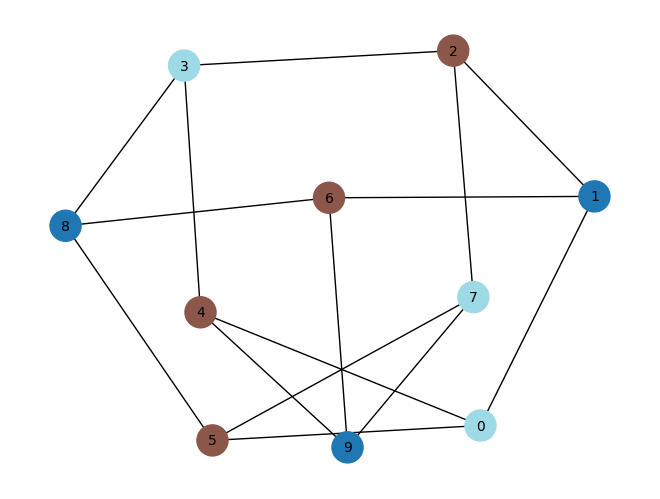

In [ ]:
# peterson - gt p10
#--------------------------------------------------------------------------------------------------------------------------------------------------------------
import random
import networkx as nx
import matplotlib.pyplot as plt

# Algorithm parameters - these are hyperparameters that control the genetic algorithm
NUM_CHROMOSOMES = 100  # Population size
CROSS_PROBABILITY = 0.85  # Probability of crossover occurring between two parents
MUTATE_PROBABILITY = 0.3  # Probability of mutation occurring in a chromosome
NUM_GENERATIONS = 1000  # Maximum number of generations to run
ELITISM_COUNT = 2  # Number of best chromosomes to carry over unchanged to next generation

class Chromosome:
    def __init__(self, num_vertices):
        # Initialize a chromosome with random colors (starting with minimal possible colors - 2)
        self.sequence = [random.randint(1, 2) for _ in range(num_vertices)]
        self.num_conflicts = 0  # Number of adjacent nodes with same color
        self.fitness = 0  # Fitness score (higher is better)
        self.update_colors_used()  # Calculate how many unique colors are being used

    def copy(self):
        # Create a deep copy of the chromosome
        new_chromosome = Chromosome(len(self.sequence))
        new_chromosome.sequence = self.sequence[:]  # Copy the color sequence
        new_chromosome.num_conflicts = self.num_conflicts
        new_chromosome.fitness = self.fitness
        new_chromosome.num_colors_used = self.num_colors_used
        return new_chromosome

    def update_colors_used(self):
        # Calculate how many unique colors are in the sequence
        self.num_colors_used = len(set(self.sequence))

def find_conflict(edges, colors):
    # Count how many edges have nodes with the same color (conflicts)
    return sum(1 for u, v in edges if colors[u] == colors[v])

def evaluate_population(edges, chromosomes):
    # Evaluate each chromosome in the population
    for chrom in chromosomes:
        chrom.num_conflicts = find_conflict(edges, chrom.sequence)
        chrom.update_colors_used()

        # Fitness function design:
        # Prioritize 1) Zero conflicts, 2) Fewer colors
        if chrom.num_conflicts == 0:
            # Maximum score for valid coloring, with bonus for fewer colors
            chrom.fitness = 10000 - chrom.num_colors_used
        else:
            # Penalize conflicts heavily
            chrom.fitness = -chrom.num_conflicts

def select_chromosomes(chromosomes):
    # Tournament selection with size 5
    selected = []
    # Select enough chromosomes to maintain population size (minus elites)
    for _ in range(len(chromosomes) - ELITISM_COUNT):
        # Randomly sample 5 chromosomes and pick the best one
        candidates = random.sample(chromosomes, 5)
        selected.append(max(candidates, key=lambda x: x.fitness).copy())
    return selected

def crossover(parent1, parent2):
    # Perform two-point crossover between two parents
    size = len(parent1.sequence)
    # Choose two random points and sort them
    pt1, pt2 = sorted(random.sample(range(size), 2))
    # Swap the segments between the two points
    parent1.sequence[pt1:pt2], parent2.sequence[pt1:pt2] = (
        parent2.sequence[pt1:pt2], parent1.sequence[pt1:pt2])

def mutate(chromosome):
    # Conflict-directed mutation - focuses on problematic nodes
    conflicting_nodes = []
    # Find all nodes involved in conflicts
    for u, v in edges:
        if chromosome.sequence[u] == chromosome.sequence[v]:
            conflicting_nodes.extend([u, v])

    # If no conflicts, mutate random nodes
    nodes_to_mutate = conflicting_nodes if conflicting_nodes else range(len(chromosome.sequence))

    # Mutate up to 5 nodes (or all if fewer than 5)
    for node in random.sample(nodes_to_mutate, min(5, len(nodes_to_mutate))):
        # Find colors of neighboring nodes
        neighbor_colors = set()
        for u, v in edges:
            if u == node:
                neighbor_colors.add(chromosome.sequence[v])
            elif v == node:
                neighbor_colors.add(chromosome.sequence[u])

        # Try to find a non-conflicting color
        current_color = chromosome.sequence[node]
        available_colors = [c for c in range(1, chromosome.num_colors_used + 2)
                          if c not in neighbor_colors]

        if available_colors:
            # Prefer smaller color numbers if available
            chromosome.sequence[node] = min(available_colors)
        else:
            # If no conflict-free color, assign smallest possible color
            chromosome.sequence[node] = min(set(range(1, chromosome.num_colors_used + 2)) - neighbor_colors,
                                          default=random.randint(1, chromosome.num_colors_used))

def genetic_algorithm(edges, num_vertices):
    # Initialize population
    population = [Chromosome(num_vertices) for _ in range(NUM_CHROMOSOMES)]
    best_solution = None

    # Main generational loop
    for generation in range(1, NUM_GENERATIONS + 1):
        evaluate_population(edges, population)

        # Track best solution found so far
        current_best = max(population, key=lambda x: x.fitness)
        if best_solution is None or (current_best.fitness > best_solution.fitness):
            best_solution = current_best.copy()

        # Early termination if perfect solution found
        if best_solution.num_conflicts == 0:
            # Try to reduce colors further if possible
            if best_solution.num_colors_used > 2:
                best_solution = try_reduce_colors(best_solution, edges)
            break

        # Print progress information
        min_conflict = min(chrom.num_conflicts for chrom in population)
        max_conflict = max(chrom.num_conflicts for chrom in population)
        avg_conflict = sum(chrom.num_conflicts for chrom in population) / NUM_CHROMOSOMES
        avg_colors = sum(chrom.num_colors_used for chrom in population) / NUM_CHROMOSOMES
        print(f"Gen {generation:3d} | Conflicts: {min_conflict:2d}-{max_conflict:2d} (avg {avg_conflict:5.1f}) | Colors: {avg_colors:4.1f}")

        # Selection and reproduction
        elites = sorted(population, key=lambda x: -x.fitness)[:ELITISM_COUNT]
        mating_pool = select_chromosomes(population)

        # Crossover
        for i in range(0, len(mating_pool) - 1, 2):
            if random.random() < CROSS_PROBABILITY:
                crossover(mating_pool[i], mating_pool[i + 1])

        # Mutation
        for chrom in mating_pool:
            if random.random() < MUTATE_PROBABILITY:
                mutate(chrom)

        # Create new population from elites and offspring
        population = elites + mating_pool[:NUM_CHROMOSOMES - ELITISM_COUNT]

    # Final optimization attempt
    if best_solution.num_conflicts == 0:
        best_solution = try_reduce_colors(best_solution, edges)

    return best_solution

def try_reduce_colors(chromosome, edges): # Try to reduce the number of colors while maintaining validity
    current_colors = chromosome.num_colors_used
    # Try to reduce colors one by one
    for target_colors in range(2, current_colors):
        color_map = {}
        used_colors = set()
        new_sequence = chromosome.sequence.copy()

        # Try to map colors to a smaller palette
        # For each node, it first identifies all colors used by its neighbors
        # Then tries to assign the smallest possible color (starting from 1) that isn't used by any neighbor
        # If no color is available at the current target palette size, the reduction fails
        for node in range(len(new_sequence)):
            original_color = new_sequence[node]
            if original_color not in color_map:
                # Find the smallest available color that doesn't conflict
                neighbor_colors = set()
                for u, v in edges:
                    if u == node:
                        neighbor_colors.add(new_sequence[v])
                    elif v == node:
                        neighbor_colors.add(new_sequence[u])

                # Try to find a non-conflicting color
                # After attempting a reduction, it checks if the new coloring is valid (no conflicts)
                # Only keeps the reduction if it's valid
                for c in range(1, target_colors + 1):
                    if c not in neighbor_colors:
                        color_map[original_color] = c
                        used_colors.add(c)
                        break
                else:
                    # If no color available, can't reduce further
                    return chromosome

            new_sequence[node] = color_map[original_color]

        # Check if the new coloring is valid
        if find_conflict(edges, new_sequence) == 0:
            chromosome.sequence = new_sequence
            chromosome.num_colors_used = len(set(new_sequence))
            print(f"Reduced to {chromosome.num_colors_used} colors")

    return chromosome

def visualize_graph_with_coloring(G, chromosome):
    # visualize the graph with node colors
    if len(chromosome.sequence) != len(G.nodes):
        print(
            f"Warning: Number of colors ({len(chromosome.sequence)}) doesn't match number of nodes ({len(G.nodes)})"
        )
        return

    # create color mapping for visualization
    node_colors = [chromosome.sequence[node] for node in range(len(G.nodes))]

    unique_colors = list(set(chromosome.sequence))
    color_map = plt.cm.get_cmap('tab20', len(unique_colors))

    color_indices = [unique_colors.index(color) for color in chromosome.sequence]
    node_colors = [color_map(i) for i in color_indices]

    # draw the graph
    pos = nx.kamada_kawai_layout(G)
    nx.draw(
        G,
        pos,
        node_color=node_colors,
        with_labels=True,
        node_size=500,
        font_size=10,
    )
    plt.show()

def get_complex_graph():
    known_chromatic_num = 10  # The known minimum number of colors needed
    num_vertices = 50
    edges = [
        (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 6),
        (2, 3), (2, 5), (2, 7), (3, 6), (3, 8), (4, 5), (4, 6), (4, 9), (5, 7),
        (5, 10), (6, 8), (6, 11), (7, 9), (7, 12), (8, 10), (8, 13), (9, 11),
        (9, 14), (10, 12), (10, 15), (11, 13), (11, 16), (12, 14), (12, 17),
        (13, 15), (13, 18), (14, 16), (14, 19), (15, 17), (15, 20), (16, 18),
        (16, 21), (17, 19), (17, 22), (18, 20), (18, 23), (19, 21), (19, 24),
        (20, 22), (20, 25), (21, 23), (21, 26), (22, 24), (22, 27), (23, 25),
        (23, 28), (24, 26), (24, 29), (25, 27), (25, 30), (26, 28), (26, 31),
        (27, 29), (27, 32), (28, 30), (28, 33), (29, 31), (29, 34), (30, 32),
        (30, 35), (31, 33), (31, 36), (32, 34), (32, 37), (33, 35), (33, 38),
        (34, 36), (34, 39), (35, 37), (35, 40), (36, 38), (36, 41), (37, 39),
        (37, 42), (38, 40), (38, 43), (39, 41), (39, 44), (40, 42), (40, 45),
        (41, 43), (41, 46), (42, 44), (42, 47), (43, 45), (43, 48), (44, 46),
        (44, 49), (45, 47), (45, 0), (46, 48), (46, 1), (47, 49), (47, 2),
        (48, 0), (48, 3), (49, 1), (49, 4), (0, 10), (0, 20), (0, 30), (0, 40),
        (1, 11), (1, 21), (1, 31), (1, 41), (2, 12), (2, 22), (2, 32), (2, 42),
        (3, 13), (3, 23), (3, 33), (3, 43), (4, 14), (4, 24), (4, 34), (4, 44),
        (5, 15), (5, 25), (5, 35), (5, 45), (6, 16), (6, 26), (6, 36), (6, 46),
        (7, 17), (7, 27), (7, 37), (7, 47), (8, 18), (8, 28), (8, 38), (8, 48),
        (9, 19), (9, 29), (9, 39), (9, 49), (10, 20), (10, 30), (10, 40),
        (11, 21), (11, 31), (11, 41), (12, 22), (12, 32), (12, 42), (13, 23),
        (13, 33), (13, 43), (14, 24), (14, 34), (14, 44), (15, 25), (15, 35),
        (15, 45), (16, 26), (16, 36), (16, 46), (17, 27), (17, 37), (17, 47),
        (18, 28), (18, 38), (18, 48), (19, 29), (19, 39), (19, 49), (20, 30),
        (20, 40), (21, 31), (21, 41), (22, 32), (22, 42), (23, 33), (23, 43),
        (24, 34), (24, 44), (25, 35), (25, 45), (26, 36), (26, 46), (27, 37),
        (27, 47), (28, 38), (28, 48), (29, 39), (29, 49), (30, 40), (31, 41),
        (32, 42), (33, 43), (34, 44), (35, 45), (36, 46), (37, 47), (38, 48),
        (39, 49)
    ]

    # Create adjacency list representation
    adjacency_list = {i: set() for i in range(num_vertices)}
    for u, v in edges:
        adjacency_list[u].add(v)
        adjacency_list[v].add(u)

    # Convert sets to sorted lists for display
    for vertex in adjacency_list:
        adjacency_list[vertex] = sorted(adjacency_list[vertex])

    return known_chromatic_num, num_vertices, edges, adjacency_list

def get_user_input():
    # Get graph parameters from user input
    print("Enter the graph parameters:")
    known_chromatic_num = int(input("Known chromatic number: "))
    num_vertices = int(input("Number of vertices: "))
    num_edges = int(input("Number of edges: "))

    # Get each edge from user
    print(f"Enter {num_edges} edges (one per line, space-separated vertices):")
    edges = []
    for _ in range(num_edges):
        u, v = map(int, input().split())
        edges.append((u, v))

    # Create adjacency list
    adjacency_list = {i: set() for i in range(num_vertices)}
    for u, v in edges:
        adjacency_list[u].add(v)
        adjacency_list[v].add(u)

    # Convert sets to sorted lists for display
    for vertex in adjacency_list:
        adjacency_list[vertex] = sorted(adjacency_list[vertex])

    return known_chromatic_num, num_vertices, edges, adjacency_list

# Main----------------
if __name__ == "__main__":
    print("Choose input method:")
    print("1. Use predefined complex graph (50 nodes, 200 edges)")
    print("2. Enter custom graph parameters")
    choice = input("Enter choice (1 or 2): ")

    if choice == "1":
        known_chromatic_num, num_vertices, edges, adjacency_list = get_complex_graph()
    else:
        known_chromatic_num, num_vertices, edges, adjacency_list = get_user_input()

    # Print input summary
    print("\nInput Summary:")
    print(f"Known chromatic number: {known_chromatic_num} (used only for reference)")
    print(f"Number of vertices: {num_vertices}")
    print(f"Number of edges: {len(edges)}")
    print("\nAdjacency List Representation:")
    for vertex in sorted(adjacency_list.keys()):
        print(f"Vertex {vertex}: {adjacency_list[vertex]}")

    # Run the genetic algorithm
    best_chromosome = genetic_algorithm(edges, num_vertices)

    # Print results
    print("\nBest Solution Found:")
    print("Sequence:", best_chromosome.sequence)
    print("Number of conflicts:", best_chromosome.num_conflicts)
    print("Number of colors used:", best_chromosome.num_colors_used)
    print("Known chromatic number (reference):", known_chromatic_num)
    print("Note: Algorithm found the minimal coloring independently")

    # Create and visualize the graph
    G = nx.Graph()
    G.add_nodes_from(range(num_vertices))
    G.add_edges_from(edges)

    visualize_graph_with_coloring(G, best_chromosome)


Choose input method:
1. Use predefined complex graph (50 nodes, 200 edges)
2. Enter custom graph parameters
Enter choice (1 or 2): 2
Enter the graph parameters:
Known chromatic number: 6
Number of vertices: 8
Number of edges: 14
Enter 14 edges (one per line, space-separated vertices):
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 0
0 2
2 4
4 6
6 0
0 4
2 6

Input Summary:
Known chromatic number: 6 (used only for reference)
Number of vertices: 8
Number of edges: 14

Adjacency List Representation:
Vertex 0: [1, 2, 4, 6, 7]
Vertex 1: [0, 2]
Vertex 2: [0, 1, 3, 4, 6]
Vertex 3: [2, 4]
Vertex 4: [0, 2, 3, 5, 6]
Vertex 5: [4, 6]
Vertex 6: [0, 2, 4, 5, 7]
Vertex 7: [0, 6]
Gen   1 | Conflicts:  4-14 (avg   7.1) | Colors:  2.0
Gen   2 | Conflicts:  1- 9 (avg   4.5) | Colors:  2.4

Best Solution Found:
Sequence: [4, 2, 1, 3, 2, 1, 3, 1]
Number of conflicts: 0
Number of colors used: 4
Known chromatic number (reference): 6
Note: Algorithm found the minimal coloring independently


<ipython-input-15-09adb3087915>:190: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_colors))


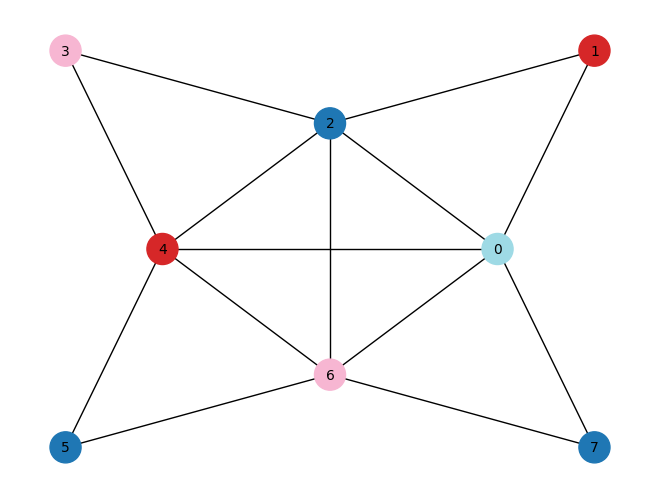

In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt

# Algorithm parameters - these are hyperparameters that control the genetic algorithm
NUM_CHROMOSOMES = 100  # Population size
CROSS_PROBABILITY = 0.85  # Probability of crossover occurring between two parents
MUTATE_PROBABILITY = 0.3  # Probability of mutation occurring in a chromosome
NUM_GENERATIONS = 1000  # Maximum number of generations to run
ELITISM_COUNT = 2  # Number of best chromosomes to carry over unchanged to next generation

class Chromosome:
    def __init__(self, num_vertices):
        # Initialize a chromosome with random colors (starting with minimal possible colors - 2)
        self.sequence = [random.randint(1, 2) for _ in range(num_vertices)]
        self.num_conflicts = 0  # Number of adjacent nodes with same color
        self.fitness = 0  # Fitness score (higher is better)
        self.update_colors_used()  # Calculate how many unique colors are being used

    def copy(self):
        # Create a deep copy of the chromosome
        new_chromosome = Chromosome(len(self.sequence))
        new_chromosome.sequence = self.sequence[:]  # Copy the color sequence
        new_chromosome.num_conflicts = self.num_conflicts
        new_chromosome.fitness = self.fitness
        new_chromosome.num_colors_used = self.num_colors_used
        return new_chromosome

    def update_colors_used(self):
        # Calculate how many unique colors are in the sequence
        self.num_colors_used = len(set(self.sequence))

def find_conflict(edges, colors):
    # Count how many edges have nodes with the same color (conflicts)
    return sum(1 for u, v in edges if colors[u] == colors[v])

def evaluate_population(edges, chromosomes):
    # Evaluate each chromosome in the population
    for chrom in chromosomes:
        chrom.num_conflicts = find_conflict(edges, chrom.sequence)
        chrom.update_colors_used()

        # Fitness function design:
        # Prioritize 1) Zero conflicts, 2) Fewer colors
        if chrom.num_conflicts == 0:
            # Maximum score for valid coloring, with bonus for fewer colors
            chrom.fitness = 10000 - chrom.num_colors_used
        else:
            # Penalize conflicts heavily
            chrom.fitness = -chrom.num_conflicts

def select_chromosomes(chromosomes):
    # Tournament selection with size 5
    selected = []
    # Select enough chromosomes to maintain population size (minus elites)
    for _ in range(len(chromosomes) - ELITISM_COUNT):
        # Randomly sample 5 chromosomes and pick the best one
        candidates = random.sample(chromosomes, 5)
        selected.append(max(candidates, key=lambda x: x.fitness).copy())
    return selected

def crossover(parent1, parent2):
    # Perform two-point crossover between two parents
    size = len(parent1.sequence)
    # Choose two random points and sort them
    pt1, pt2 = sorted(random.sample(range(size), 2))
    # Swap the segments between the two points
    parent1.sequence[pt1:pt2], parent2.sequence[pt1:pt2] = (
        parent2.sequence[pt1:pt2], parent1.sequence[pt1:pt2])

def mutate(chromosome):
    # Conflict-directed mutation - focuses on problematic nodes
    conflicting_nodes = []
    # Find all nodes involved in conflicts
    for u, v in edges:
        if chromosome.sequence[u] == chromosome.sequence[v]:
            conflicting_nodes.extend([u, v])

    # If no conflicts, mutate random nodes
    nodes_to_mutate = conflicting_nodes if conflicting_nodes else range(len(chromosome.sequence))

    # Mutate up to 5 nodes (or all if fewer than 5)
    for node in random.sample(nodes_to_mutate, min(5, len(nodes_to_mutate))):
        # Find colors of neighboring nodes
        neighbor_colors = set()
        for u, v in edges:
            if u == node:
                neighbor_colors.add(chromosome.sequence[v])
            elif v == node:
                neighbor_colors.add(chromosome.sequence[u])

        # Try to find a non-conflicting color
        current_color = chromosome.sequence[node]
        available_colors = [c for c in range(1, chromosome.num_colors_used + 2)
                          if c not in neighbor_colors]

        if available_colors:
            # Prefer smaller color numbers if available
            chromosome.sequence[node] = min(available_colors)
        else:
            # If no conflict-free color, assign smallest possible color
            chromosome.sequence[node] = min(set(range(1, chromosome.num_colors_used + 2)) - neighbor_colors,
                                          default=random.randint(1, chromosome.num_colors_used))

def genetic_algorithm(edges, num_vertices):
    # Initialize population
    population = [Chromosome(num_vertices) for _ in range(NUM_CHROMOSOMES)]
    best_solution = None

    # Main generational loop
    for generation in range(1, NUM_GENERATIONS + 1):
        evaluate_population(edges, population)

        # Track best solution found so far
        current_best = max(population, key=lambda x: x.fitness)
        if best_solution is None or (current_best.fitness > best_solution.fitness):
            best_solution = current_best.copy()

        # Early termination if perfect solution found
        if best_solution.num_conflicts == 0:
            # Try to reduce colors further if possible
            if best_solution.num_colors_used > 2:
                best_solution = try_reduce_colors(best_solution, edges)
            break

        # Print progress information
        min_conflict = min(chrom.num_conflicts for chrom in population)
        max_conflict = max(chrom.num_conflicts for chrom in population)
        avg_conflict = sum(chrom.num_conflicts for chrom in population) / NUM_CHROMOSOMES
        avg_colors = sum(chrom.num_colors_used for chrom in population) / NUM_CHROMOSOMES
        print(f"Gen {generation:3d} | Conflicts: {min_conflict:2d}-{max_conflict:2d} (avg {avg_conflict:5.1f}) | Colors: {avg_colors:4.1f}")

        # Selection and reproduction
        elites = sorted(population, key=lambda x: -x.fitness)[:ELITISM_COUNT]
        mating_pool = select_chromosomes(population)

        # Crossover
        for i in range(0, len(mating_pool) - 1, 2):
            if random.random() < CROSS_PROBABILITY:
                crossover(mating_pool[i], mating_pool[i + 1])

        # Mutation
        for chrom in mating_pool:
            if random.random() < MUTATE_PROBABILITY:
                mutate(chrom)

        # Create new population from elites and offspring
        population = elites + mating_pool[:NUM_CHROMOSOMES - ELITISM_COUNT]

    # Final optimization attempt
    if best_solution.num_conflicts == 0:
        best_solution = try_reduce_colors(best_solution, edges)

    return best_solution

def try_reduce_colors(chromosome, edges):
    """Try to reduce the number of colors while maintaining validity"""
    current_colors = chromosome.num_colors_used
    # Try to reduce colors one by one
    for target_colors in range(2, current_colors):
        color_map = {}
        used_colors = set()
        new_sequence = chromosome.sequence.copy()

        # Try to map colors to a smaller palette
        # For each node, it first identifies all colors used by its neighbors
        # Then tries to assign the smallest possible color (starting from 1) that isn't used by any neighbor
        # If no color is available at the current target palette size, the reduction fails
        for node in range(len(new_sequence)):
            original_color = new_sequence[node]
            if original_color not in color_map:
                # Find the smallest available color that doesn't conflict
                neighbor_colors = set()
                for u, v in edges:
                    if u == node:
                        neighbor_colors.add(new_sequence[v])
                    elif v == node:
                        neighbor_colors.add(new_sequence[u])

                # Try to find a non-conflicting color
                # After attempting a reduction, it checks if the new coloring is valid (no conflicts)
                # Only keeps the reduction if it's valid
                for c in range(1, target_colors + 1):
                    if c not in neighbor_colors:
                        color_map[original_color] = c
                        used_colors.add(c)
                        break
                else:
                    # If no color available, can't reduce further
                    return chromosome

            new_sequence[node] = color_map[original_color]

        # Check if the new coloring is valid
        if find_conflict(edges, new_sequence) == 0:
            chromosome.sequence = new_sequence
            chromosome.num_colors_used = len(set(new_sequence))
            print(f"Reduced to {chromosome.num_colors_used} colors")

    return chromosome

def visualize_graph_with_coloring(G, chromosome):
    # Visualize the graph with node colors
    if len(chromosome.sequence) != len(G.nodes):
        print(
            f"Warning: Number of colors ({len(chromosome.sequence)}) doesn't match number of nodes ({len(G.nodes)})"
        )
        return

    # Create color mapping for visualization
    node_colors = [chromosome.sequence[node] for node in range(len(G.nodes))]

    unique_colors = list(set(chromosome.sequence))
    color_map = plt.cm.get_cmap('tab20', len(unique_colors))

    color_indices = [unique_colors.index(color) for color in chromosome.sequence]
    node_colors = [color_map(i) for i in color_indices]

    # Draw the graph
    pos = nx.kamada_kawai_layout(G)
    nx.draw(
        G,
        pos,
        node_color=node_colors,
        with_labels=True,
        node_size=500,
        font_size=10,
    )
    plt.show()

def get_complex_graph():
    """Returns a predefined complex graph with 50 nodes and 200 edges"""
    known_chromatic_num = 10  # The known minimum number of colors needed
    num_vertices = 50
    edges = [
        (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 6),
        (2, 3), (2, 5), (2, 7), (3, 6), (3, 8), (4, 5), (4, 6), (4, 9), (5, 7),
        (5, 10), (6, 8), (6, 11), (7, 9), (7, 12), (8, 10), (8, 13), (9, 11),
        (9, 14), (10, 12), (10, 15), (11, 13), (11, 16), (12, 14), (12, 17),
        (13, 15), (13, 18), (14, 16), (14, 19), (15, 17), (15, 20), (16, 18),
        (16, 21), (17, 19), (17, 22), (18, 20), (18, 23), (19, 21), (19, 24),
        (20, 22), (20, 25), (21, 23), (21, 26), (22, 24), (22, 27), (23, 25),
        (23, 28), (24, 26), (24, 29), (25, 27), (25, 30), (26, 28), (26, 31),
        (27, 29), (27, 32), (28, 30), (28, 33), (29, 31), (29, 34), (30, 32),
        (30, 35), (31, 33), (31, 36), (32, 34), (32, 37), (33, 35), (33, 38),
        (34, 36), (34, 39), (35, 37), (35, 40), (36, 38), (36, 41), (37, 39),
        (37, 42), (38, 40), (38, 43), (39, 41), (39, 44), (40, 42), (40, 45),
        (41, 43), (41, 46), (42, 44), (42, 47), (43, 45), (43, 48), (44, 46),
        (44, 49), (45, 47), (45, 0), (46, 48), (46, 1), (47, 49), (47, 2),
        (48, 0), (48, 3), (49, 1), (49, 4), (0, 10), (0, 20), (0, 30), (0, 40),
        (1, 11), (1, 21), (1, 31), (1, 41), (2, 12), (2, 22), (2, 32), (2, 42),
        (3, 13), (3, 23), (3, 33), (3, 43), (4, 14), (4, 24), (4, 34), (4, 44),
        (5, 15), (5, 25), (5, 35), (5, 45), (6, 16), (6, 26), (6, 36), (6, 46),
        (7, 17), (7, 27), (7, 37), (7, 47), (8, 18), (8, 28), (8, 38), (8, 48),
        (9, 19), (9, 29), (9, 39), (9, 49), (10, 20), (10, 30), (10, 40),
        (11, 21), (11, 31), (11, 41), (12, 22), (12, 32), (12, 42), (13, 23),
        (13, 33), (13, 43), (14, 24), (14, 34), (14, 44), (15, 25), (15, 35),
        (15, 45), (16, 26), (16, 36), (16, 46), (17, 27), (17, 37), (17, 47),
        (18, 28), (18, 38), (18, 48), (19, 29), (19, 39), (19, 49), (20, 30),
        (20, 40), (21, 31), (21, 41), (22, 32), (22, 42), (23, 33), (23, 43),
        (24, 34), (24, 44), (25, 35), (25, 45), (26, 36), (26, 46), (27, 37),
        (27, 47), (28, 38), (28, 48), (29, 39), (29, 49), (30, 40), (31, 41),
        (32, 42), (33, 43), (34, 44), (35, 45), (36, 46), (37, 47), (38, 48),
        (39, 49)
    ]

    # Create adjacency list representation
    adjacency_list = {i: set() for i in range(num_vertices)}
    for u, v in edges:
        adjacency_list[u].add(v)
        adjacency_list[v].add(u)

    # Convert sets to sorted lists for display
    for vertex in adjacency_list:
        adjacency_list[vertex] = sorted(adjacency_list[vertex])

    return known_chromatic_num, num_vertices, edges, adjacency_list

def get_user_input():
    # Get graph parameters from user input
    print("Enter the graph parameters:")
    known_chromatic_num = int(input("Known chromatic number: "))
    num_vertices = int(input("Number of vertices: "))
    num_edges = int(input("Number of edges: "))

    # Get each edge from user
    print(f"Enter {num_edges} edges (one per line, space-separated vertices):")
    edges = []
    for _ in range(num_edges):
        u, v = map(int, input().split())
        edges.append((u, v))

    # Create adjacency list
    adjacency_list = {i: set() for i in range(num_vertices)}
    for u, v in edges:
        adjacency_list[u].add(v)
        adjacency_list[v].add(u)

    # Convert sets to sorted lists for display
    for vertex in adjacency_list:
        adjacency_list[vertex] = sorted(adjacency_list[vertex])

    return known_chromatic_num, num_vertices, edges, adjacency_list

# Main execution
if __name__ == "__main__":
    print("Choose input method:")
    print("1. Use predefined complex graph (50 nodes, 200 edges)")
    print("2. Enter custom graph parameters")
    choice = input("Enter choice (1 or 2): ")

    if choice == "1":
        known_chromatic_num, num_vertices, edges, adjacency_list = get_complex_graph()
    else:
        known_chromatic_num, num_vertices, edges, adjacency_list = get_user_input()

    # Print input summary
    print("\nInput Summary:")
    print(f"Known chromatic number: {known_chromatic_num} (used only for reference)")
    print(f"Number of vertices: {num_vertices}")
    print(f"Number of edges: {len(edges)}")
    print("\nAdjacency List Representation:")
    for vertex in sorted(adjacency_list.keys()):
        print(f"Vertex {vertex}: {adjacency_list[vertex]}")

    # Run the genetic algorithm
    best_chromosome = genetic_algorithm(edges, num_vertices)

    # Print results
    print("\nBest Solution Found:")
    print("Sequence:", best_chromosome.sequence)
    print("Number of conflicts:", best_chromosome.num_conflicts)
    print("Number of colors used:", best_chromosome.num_colors_used)
    print("Known chromatic number (reference):", known_chromatic_num)
    print("Note: Algorithm found the minimal coloring independently")

    # Create and visualize the graph
    G = nx.Graph()
    G.add_nodes_from(range(num_vertices))
    G.add_edges_from(edges)

    visualize_graph_with_coloring(G, best_chromosome)

#     Choose input method:
# 1. Use predefined complex graph (50 nodes, 200 edges)
# 2. Enter custom graph parameters
# Enter choice (1 or 2): 2
# Enter the graph parameters:
# Known chromatic number: 5
# Number of vertices: 4
# Number of edges: 5
# Enter 5 edges (one per line, space-separated vertices):
# 0 1
# 0 2
# 0 3
# 1 3
# 2 3

Choose input method:
1. Use predefined complex graph (50 nodes, 200 edges)
2. Enter custom graph parameters
Enter choice (1 or 2): 1

Input Summary:
Known chromatic number: 10 (used only for reference)
Number of vertices: 50
Number of edges: 207

Adjacency List Representation:
Vertex 0: [1, 2, 3, 4, 5, 10, 20, 30, 40, 45, 48]
Vertex 1: [0, 2, 3, 4, 6, 11, 21, 31, 41, 46, 49]
Vertex 2: [0, 1, 3, 5, 7, 12, 22, 32, 42, 47]
Vertex 3: [0, 1, 2, 6, 8, 13, 23, 33, 43, 48]
Vertex 4: [0, 1, 5, 6, 9, 14, 24, 34, 44, 49]
Vertex 5: [0, 2, 4, 7, 10, 15, 25, 35, 45]
Vertex 6: [1, 3, 4, 8, 11, 16, 26, 36, 46]
Vertex 7: [2, 5, 9, 12, 17, 27, 37, 47]
Vertex 8: [3, 6, 10, 13, 18, 28, 38, 48]
Vertex 9: [4, 7, 11, 14, 19, 29, 39, 49]
Vertex 10: [0, 5, 8, 12, 15, 20, 30, 40]
Vertex 11: [1, 6, 9, 13, 16, 21, 31, 41]
Vertex 12: [2, 7, 10, 14, 17, 22, 32, 42]
Vertex 13: [3, 8, 11, 15, 18, 23, 33, 43]
Vertex 14: [4, 9, 12, 16, 19, 24, 34, 44]
Vertex 15: [5, 10, 13, 17, 20, 25, 35, 45]
Vertex 16: [6, 11, 14, 18

<ipython-input-7-ef37e08bdb7a>:191: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_colors))


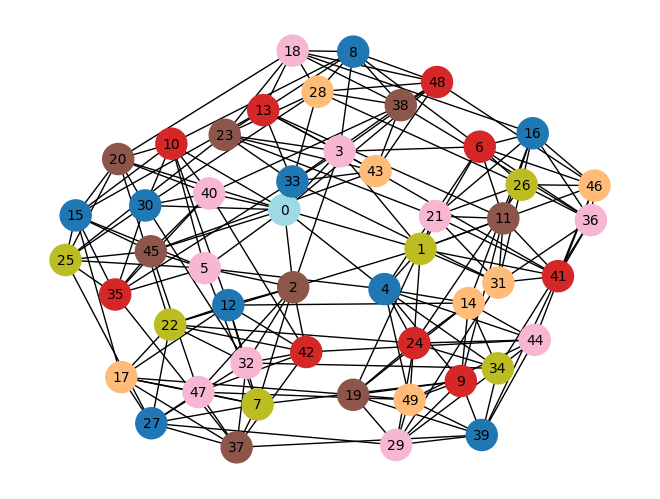

In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt

# Algorithm parameters - these are hyperparameters that control the genetic algorithm
NUM_CHROMOSOMES = 100  # Population size
CROSS_PROBABILITY = 0.85  # Probability of crossover occurring between two parents
MUTATE_PROBABILITY = 0.3  # Probability of mutation occurring in a chromosome
NUM_GENERATIONS = 1000  # Maximum number of generations to run
ELITISM_COUNT = 2  # Number of best chromosomes to carry over unchanged to next generation

class Chromosome:
    def __init__(self, num_vertices):
        # Initialize a chromosome with random colors (starting with minimal possible colors - 2)
        self.sequence = [random.randint(1, 2) for _ in range(num_vertices)]
        self.num_conflicts = 0  # Number of adjacent nodes with same color
        self.fitness = 0  # Fitness score (higher is better)
        self.update_colors_used()  # Calculate how many unique colors are being used

    def copy(self):
        # Create a deep copy of the chromosome
        new_chromosome = Chromosome(len(self.sequence))
        new_chromosome.sequence = self.sequence[:]  # Copy the color sequence
        new_chromosome.num_conflicts = self.num_conflicts
        new_chromosome.fitness = self.fitness
        new_chromosome.num_colors_used = self.num_colors_used
        return new_chromosome

    def update_colors_used(self):
        # Calculate how many unique colors are in the sequence
        self.num_colors_used = len(set(self.sequence))

def find_conflict(edges, colors):
    # Count how many edges have nodes with the same color (conflicts)
    return sum(1 for u, v in edges if colors[u] == colors[v])

def evaluate_population(edges, chromosomes):
    # Evaluate each chromosome in the population
    for chrom in chromosomes:
        chrom.num_conflicts = find_conflict(edges, chrom.sequence)
        chrom.update_colors_used()

        # Fitness function design:
        # Prioritize 1) Zero conflicts, 2) Fewer colors
        if chrom.num_conflicts == 0:
            # Maximum score for valid coloring, with bonus for fewer colors
            chrom.fitness = 10000 - chrom.num_colors_used
        else:
            # Penalize conflicts heavily
            chrom.fitness = -chrom.num_conflicts

def select_chromosomes(chromosomes):
    # Tournament selection with size 5
    selected = []
    # Select enough chromosomes to maintain population size (minus elites)
    for _ in range(len(chromosomes) - ELITISM_COUNT):
        # Randomly sample 5 chromosomes and pick the best one
        candidates = random.sample(chromosomes, 5)
        selected.append(max(candidates, key=lambda x: x.fitness).copy())
    return selected

def crossover(parent1, parent2):
    # Perform two-point crossover between two parents
    size = len(parent1.sequence)
    # Choose two random points and sort them
    pt1, pt2 = sorted(random.sample(range(size), 2))
    # Swap the segments between the two points
    parent1.sequence[pt1:pt2], parent2.sequence[pt1:pt2] = (
        parent2.sequence[pt1:pt2], parent1.sequence[pt1:pt2])

def mutate(chromosome):
    # Conflict-directed mutation - focuses on problematic nodes
    conflicting_nodes = []
    # Find all nodes involved in conflicts
    for u, v in edges:
        if chromosome.sequence[u] == chromosome.sequence[v]:
            conflicting_nodes.extend([u, v])

    # If no conflicts, mutate random nodes
    nodes_to_mutate = conflicting_nodes if conflicting_nodes else range(len(chromosome.sequence))

    # Mutate up to 5 nodes (or all if fewer than 5)
    for node in random.sample(nodes_to_mutate, min(5, len(nodes_to_mutate))):
        # Find colors of neighboring nodes
        neighbor_colors = set()
        for u, v in edges:
            if u == node:
                neighbor_colors.add(chromosome.sequence[v])
            elif v == node:
                neighbor_colors.add(chromosome.sequence[u])

        # Try to find a non-conflicting color
        current_color = chromosome.sequence[node]
        available_colors = [c for c in range(1, chromosome.num_colors_used + 2)
                          if c not in neighbor_colors]

        if available_colors:
            # Prefer smaller color numbers if available
            chromosome.sequence[node] = min(available_colors)
        else:
            # If no conflict-free color, assign smallest possible color
            chromosome.sequence[node] = min(set(range(1, chromosome.num_colors_used + 2)) - neighbor_colors,
                                          default=random.randint(1, chromosome.num_colors_used))

def genetic_algorithm(edges, num_vertices):
    # Initialize population
    population = [Chromosome(num_vertices) for _ in range(NUM_CHROMOSOMES)]
    best_solution = None

    # Main generational loop
    for generation in range(1, NUM_GENERATIONS + 1):
        evaluate_population(edges, population)

        # Track best solution found so far
        current_best = max(population, key=lambda x: x.fitness)
        if best_solution is None or (current_best.fitness > best_solution.fitness):
            best_solution = current_best.copy()

        # Early termination if perfect solution found
        if best_solution.num_conflicts == 0:
            # Try to reduce colors further if possible
            if best_solution.num_colors_used > 2:
                best_solution = try_reduce_colors(best_solution, edges)
            break

        # Print progress information
        min_conflict = min(chrom.num_conflicts for chrom in population)
        max_conflict = max(chrom.num_conflicts for chrom in population)
        avg_conflict = sum(chrom.num_conflicts for chrom in population) / NUM_CHROMOSOMES
        avg_colors = sum(chrom.num_colors_used for chrom in population) / NUM_CHROMOSOMES
        print(f"Gen {generation:3d} | Conflicts: {min_conflict:2d}-{max_conflict:2d} (avg {avg_conflict:5.1f}) | Colors: {avg_colors:4.1f}")

        # Selection and reproduction
        elites = sorted(population, key=lambda x: -x.fitness)[:ELITISM_COUNT]
        mating_pool = select_chromosomes(population)

        # Crossover
        for i in range(0, len(mating_pool) - 1, 2):
            if random.random() < CROSS_PROBABILITY:
                crossover(mating_pool[i], mating_pool[i + 1])

        # Mutation
        for chrom in mating_pool:
            if random.random() < MUTATE_PROBABILITY:
                mutate(chrom)

        # Create new population from elites and offspring
        population = elites + mating_pool[:NUM_CHROMOSOMES - ELITISM_COUNT]

    # Final optimization attempt
    if best_solution.num_conflicts == 0:
        best_solution = try_reduce_colors(best_solution, edges)

    return best_solution

def try_reduce_colors(chromosome, edges):
    """Try to reduce the number of colors while maintaining validity"""
    current_colors = chromosome.num_colors_used
    # Try to reduce colors one by one
    for target_colors in range(2, current_colors):
        color_map = {}
        used_colors = set()
        new_sequence = chromosome.sequence.copy()

        # Try to map colors to a smaller palette
        # For each node, it first identifies all colors used by its neighbors
        # Then tries to assign the smallest possible color (starting from 1) that isn't used by any neighbor
        # If no color is available at the current target palette size, the reduction fails
        for node in range(len(new_sequence)):
            original_color = new_sequence[node]
            if original_color not in color_map:
                # Find the smallest available color that doesn't conflict
                neighbor_colors = set()
                for u, v in edges:
                    if u == node:
                        neighbor_colors.add(new_sequence[v])
                    elif v == node:
                        neighbor_colors.add(new_sequence[u])

                # Try to find a non-conflicting color
                # After attempting a reduction, it checks if the new coloring is valid (no conflicts)
                # Only keeps the reduction if it's valid
                for c in range(1, target_colors + 1):
                    if c not in neighbor_colors:
                        color_map[original_color] = c
                        used_colors.add(c)
                        break
                else:
                    # If no color available, can't reduce further
                    return chromosome

            new_sequence[node] = color_map[original_color]

        # Check if the new coloring is valid
        if find_conflict(edges, new_sequence) == 0:
            chromosome.sequence = new_sequence
            chromosome.num_colors_used = len(set(new_sequence))
            print(f"Reduced to {chromosome.num_colors_used} colors")

    return chromosome

def visualize_graph_with_coloring(G, chromosome):
    # Visualize the graph with node colors
    if len(chromosome.sequence) != len(G.nodes):
        print(
            f"Warning: Number of colors ({len(chromosome.sequence)}) doesn't match number of nodes ({len(G.nodes)})"
        )
        return

    # Create color mapping for visualization
    node_colors = [chromosome.sequence[node] for node in range(len(G.nodes))]

    unique_colors = list(set(chromosome.sequence))
    color_map = plt.cm.get_cmap('tab20', len(unique_colors))

    color_indices = [unique_colors.index(color) for color in chromosome.sequence]
    node_colors = [color_map(i) for i in color_indices]

    # Draw the graph
    pos = nx.kamada_kawai_layout(G)
    nx.draw(
        G,
        pos,
        node_color=node_colors,
        with_labels=True,
        node_size=500,
        font_size=10,
    )
    plt.show()

def get_complex_graph():
    """Returns a predefined complex graph with 50 nodes and 200 edges"""
    known_chromatic_num = 10  # The known minimum number of colors needed
    num_vertices = 50
    edges = [
        (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 6),
        (2, 3), (2, 5), (2, 7), (3, 6), (3, 8), (4, 5), (4, 6), (4, 9), (5, 7),
        (5, 10), (6, 8), (6, 11), (7, 9), (7, 12), (8, 10), (8, 13), (9, 11),
        (9, 14), (10, 12), (10, 15), (11, 13), (11, 16), (12, 14), (12, 17),
        (13, 15), (13, 18), (14, 16), (14, 19), (15, 17), (15, 20), (16, 18),
        (16, 21), (17, 19), (17, 22), (18, 20), (18, 23), (19, 21), (19, 24),
        (20, 22), (20, 25), (21, 23), (21, 26), (22, 24), (22, 27), (23, 25),
        (23, 28), (24, 26), (24, 29), (25, 27), (25, 30), (26, 28), (26, 31),
        (27, 29), (27, 32), (28, 30), (28, 33), (29, 31), (29, 34), (30, 32),
        (30, 35), (31, 33), (31, 36), (32, 34), (32, 37), (33, 35), (33, 38),
        (34, 36), (34, 39), (35, 37), (35, 40), (36, 38), (36, 41), (37, 39),
        (37, 42), (38, 40), (38, 43), (39, 41), (39, 44), (40, 42), (40, 45),
        (41, 43), (41, 46), (42, 44), (42, 47), (43, 45), (43, 48), (44, 46),
        (44, 49), (45, 47), (45, 0), (46, 48), (46, 1), (47, 49), (47, 2),
        (48, 0), (48, 3), (49, 1), (49, 4), (0, 10), (0, 20), (0, 30), (0, 40),
        (1, 11), (1, 21), (1, 31), (1, 41), (2, 12), (2, 22), (2, 32), (2, 42),
        (3, 13), (3, 23), (3, 33), (3, 43), (4, 14), (4, 24), (4, 34), (4, 44),
        (5, 15), (5, 25), (5, 35), (5, 45), (6, 16), (6, 26), (6, 36), (6, 46),
        (7, 17), (7, 27), (7, 37), (7, 47), (8, 18), (8, 28), (8, 38), (8, 48),
        (9, 19), (9, 29), (9, 39), (9, 49), (10, 20), (10, 30), (10, 40),
        (11, 21), (11, 31), (11, 41), (12, 22), (12, 32), (12, 42), (13, 23),
        (13, 33), (13, 43), (14, 24), (14, 34), (14, 44), (15, 25), (15, 35),
        (15, 45), (16, 26), (16, 36), (16, 46), (17, 27), (17, 37), (17, 47),
        (18, 28), (18, 38), (18, 48), (19, 29), (19, 39), (19, 49), (20, 30),
        (20, 40), (21, 31), (21, 41), (22, 32), (22, 42), (23, 33), (23, 43),
        (24, 34), (24, 44), (25, 35), (25, 45), (26, 36), (26, 46), (27, 37),
        (27, 47), (28, 38), (28, 48), (29, 39), (29, 49), (30, 40), (31, 41),
        (32, 42), (33, 43), (34, 44), (35, 45), (36, 46), (37, 47), (38, 48),
        (39, 49)
    ]

    # Create adjacency list representation
    adjacency_list = {i: set() for i in range(num_vertices)}
    for u, v in edges:
        adjacency_list[u].add(v)
        adjacency_list[v].add(u)

    # Convert sets to sorted lists for display
    for vertex in adjacency_list:
        adjacency_list[vertex] = sorted(adjacency_list[vertex])

    return known_chromatic_num, num_vertices, edges, adjacency_list

def get_user_input():
    # Get graph parameters from user input
    print("Enter the graph parameters:")
    known_chromatic_num = int(input("Known chromatic number: "))
    num_vertices = int(input("Number of vertices: "))
    num_edges = int(input("Number of edges: "))

    # Get each edge from user
    print(f"Enter {num_edges} edges (one per line, space-separated vertices):")
    edges = []
    for _ in range(num_edges):
        u, v = map(int, input().split())
        edges.append((u, v))

    # Create adjacency list
    adjacency_list = {i: set() for i in range(num_vertices)}
    for u, v in edges:
        adjacency_list[u].add(v)
        adjacency_list[v].add(u)

    # Convert sets to sorted lists for display
    for vertex in adjacency_list:
        adjacency_list[vertex] = sorted(adjacency_list[vertex])

    return known_chromatic_num, num_vertices, edges, adjacency_list

# Main execution
if __name__ == "__main__":
    print("Choose input method:")
    print("1. Use predefined complex graph (50 nodes, 200 edges)")
    print("2. Enter custom graph parameters")
    choice = input("Enter choice (1 or 2): ")

    if choice == "1":
        known_chromatic_num, num_vertices, edges, adjacency_list = get_complex_graph()
    else:
        known_chromatic_num, num_vertices, edges, adjacency_list = get_user_input()

    # Print input summary
    print("\nInput Summary:")
    print(f"Known chromatic number: {known_chromatic_num} (used only for reference)")
    print(f"Number of vertices: {num_vertices}")
    print(f"Number of edges: {len(edges)}")
    print("\nAdjacency List Representation:")
    for vertex in sorted(adjacency_list.keys()):
        print(f"Vertex {vertex}: {adjacency_list[vertex]}")

    # Run the genetic algorithm
    best_chromosome = genetic_algorithm(edges, num_vertices)

    # Print results
    print("\nBest Solution Found:")
    print("Sequence:", best_chromosome.sequence)
    print("Number of conflicts:", best_chromosome.num_conflicts)
    print("Number of colors used:", best_chromosome.num_colors_used)
    print("Known chromatic number (reference):", known_chromatic_num)
    print("Note: Algorithm found the minimal coloring independently")

    # Create and visualize the graph
    G = nx.Graph()
    G.add_nodes_from(range(num_vertices))
    G.add_edges_from(edges)

    visualize_graph_with_coloring(G, best_chromosome)

#     Choose input method:
# 1. Use predefined complex graph (50 nodes, 200 edges)
# 2. Enter custom graph parameters
# Enter choice (1 or 2): 2
# Enter the graph parameters:
# Known chromatic number: 5
# Number of vertices: 4
# Number of edges: 5
# Enter 5 edges (one per line, space-separated vertices):
# 0 1
# 0 2
# 0 3
# 1 3
# 2 3